# Definition

- 미국 SnP 500의 추세를 확인하고, PCA 분석을 통해 흐름을 주도하는 주요인을 확인힌다.

## package 세팅 및 데이터 세팅

### 패키지

In [66]:
!pip install finance-datareader
!pip install pandas --upgrade
!pip install tables --upgrade
!pip install statsmodels --upgrade
!pip install yfinance

In [67]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from matplotlib.ticker import FuncFormatter

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import FinanceDataReader as fdr
import yfinance as yf
from pandas_datareader import data

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

### help function

In [68]:
def write_from_fdr(symbols, start_date = "2010-01-01", return_erros=False):

    end = datetime.today().strftime("%Y-%m-%d")
    prices = pd.DataFrame()
    errors = []
    for ticker in symbols:
        try:
            price = fdr.DataReader(ticker, start_date, end).assign(ticker=ticker)
            prices = pd.concat([prices, price], axis=0)
        except:
            errors.append(ticker)
    if return_erros:
        return prices, errors
    return prices

def write_from_yf(symbols, market, start_date = "2019-01-01", return_erros=False):

    end = datetime.today().strftime("%Y-%m-%d")
    prices = pd.DataFrame()
    errors = []
    for ticker in snp500_stocks.Symbol:
        try:
            price = yf.download(ticker, start=start_date, end=end).assign(ticker=ticker)
            prices = pd.concat([prices, price], axis=0)
        except:
            errors.append(ticker)
    return prices

In [69]:
def clip_returns(returns):
    normed_returns = scale(returns
                        .clip(lower=returns.quantile(q=.025),
                              upper=returns.quantile(q=.975),
                              axis=1)
                        .apply(lambda x: x.sub(x.mean()).div(x.std())))
    returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
    returns = returns.dropna(thresh=int(returns.shape[1] * .95))
    # returns.info()
    return returns

### 데이터 준비
- 기본적으로 연간 데이터를 기반으로 분석합니다.
- period_start와 period_end를 지정하면 기간 분석을 수행 합니다.
  - period_start: 2023, period_end: 2023이라면 2023년 1년 기간입니다.
  - period_start: 2020, period_end: 2021이라면 2020-2021년 2년 기간입니다.
- stock_range는 분석을 실시한 stock의 수이고, 시가총액 상위 순서로 지정 합니다.   
  - 50이라면 시가총액 상위 50개를 지정합니다.

In [70]:
stock_range = 50  #계산에 사용할 stock의 수
period_start = '2023'
period_end = '2023'

#### 데이터 다운로드

In [71]:
snp500_stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)[0]
snp500_stocks.Symbol = snp500_stocks.Symbol.apply(lambda x: x.replace('.','-'))

In [72]:
prices = write_from_yf(snp500_stocks.Symbol, market="s&p500",start_date=f'{period_start}-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [73]:
prices = prices.reset_index().set_index(['Date','ticker'])

In [74]:
market_cap = {ticker : yf.Ticker(ticker).get_info()['marketCap'] for ticker in  snp500_stocks.Symbol}
market_cap = pd.DataFrame(market_cap.values(),index = market_cap.keys(), columns=['cap']).sort_values(by='cap', ascending=False)
market_cap = market_cap.drop(index='GOOG')

#### return 계산

##### 시가 총액 기준 상위: 현재 기준

In [75]:
idx = pd.IndexSlice
cols = market_cap[:stock_range].index
len(cols)

50

In [76]:
returns = prices.loc[idx[:, cols],'Adj Close'].unstack('ticker').pct_change()
# returns.info()
returns = returns[period_start:period_end]

In [77]:
columns = {ticker:name for ticker, name in zip(snp500_stocks.Symbol	, snp500_stocks.Security)}
returns = returns.rename(columns=columns)
returns = clip_returns(returns)

## 데이터 분석

### cov 클러스터맵
- 각 stock의 상관 관계를 표시

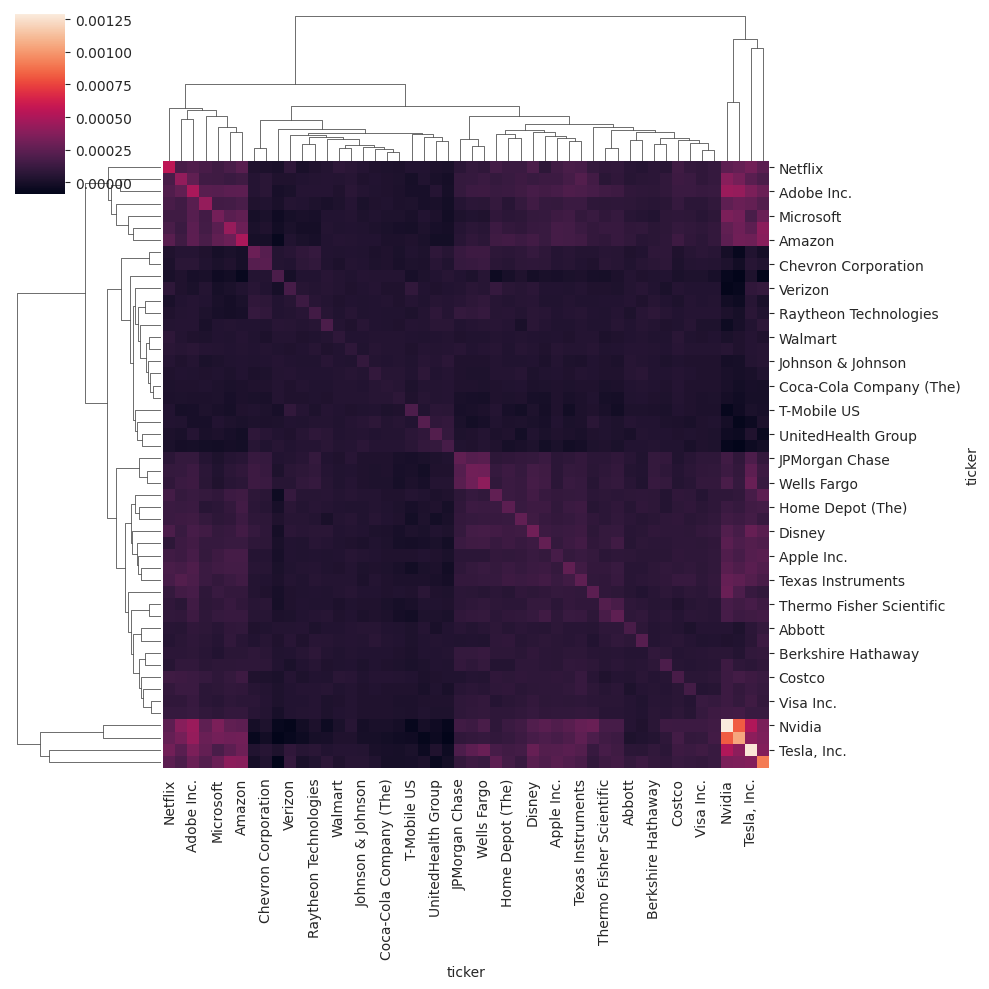

In [78]:
cov = returns.cov()
sns.clustermap(cov)

### PCA 분석 후 component별 비중
- 설명력이 높은 PCA의 components에서 weight가 높은 stock이 시장에 큰 영향을 준다.

In [79]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,70.80%
1,8.78%
2,7.15%
3,3.55%
4,1.75%


In [80]:
top4 = pd.DataFrame(pca.components_[:5], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(5)]

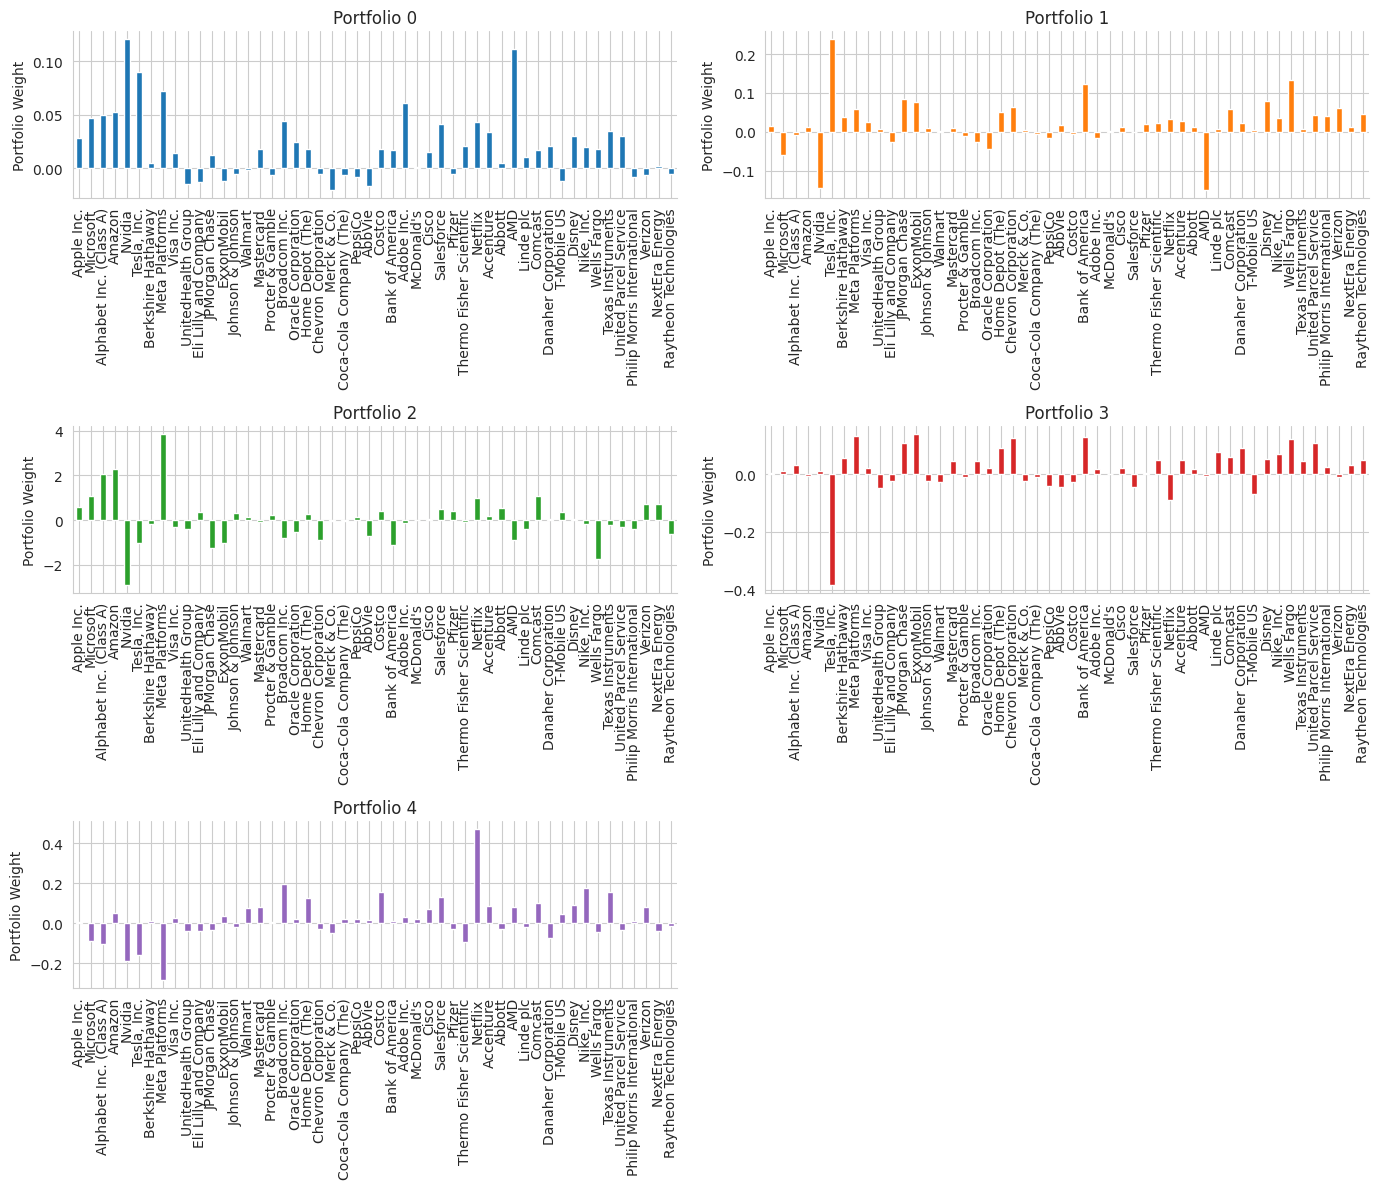

In [81]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(3, 2),
                                   figsize=(14, 12),
                                   legend=False,
                                   sharex=False,
                                   sharey=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### PCA 분석 후 component별 수익률
- 시장(The market)을 기준으로 각 Porfolio가 어떻게 움직였는지 알 수 있다.
- 각 Porfolio를 모두 합하면 시장(The market)이 될 수 있다.
- Porfolio는 시장의 성향이라고 볼 수 있다.

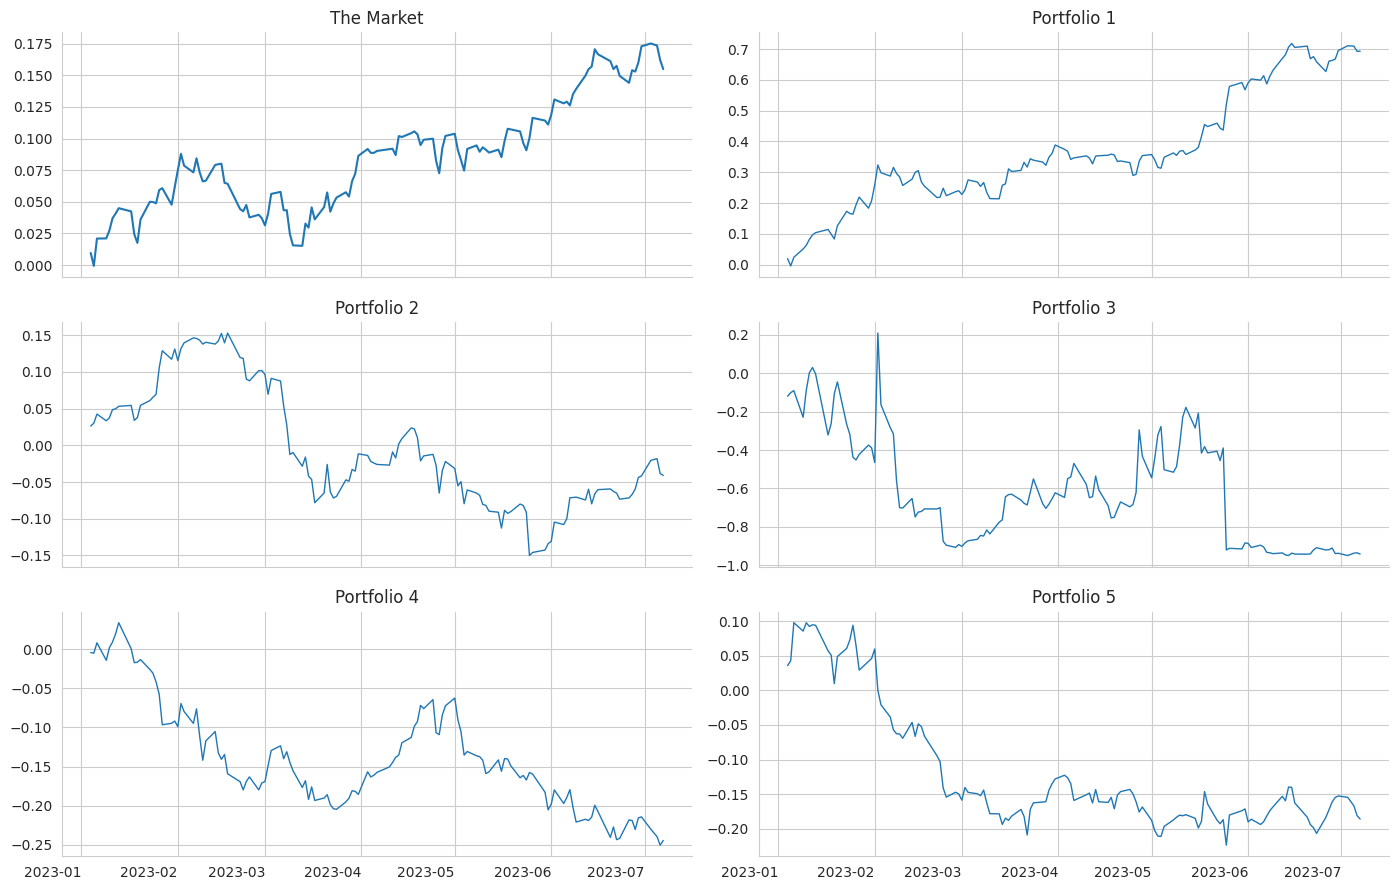

In [82]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 9), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(5):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(6):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

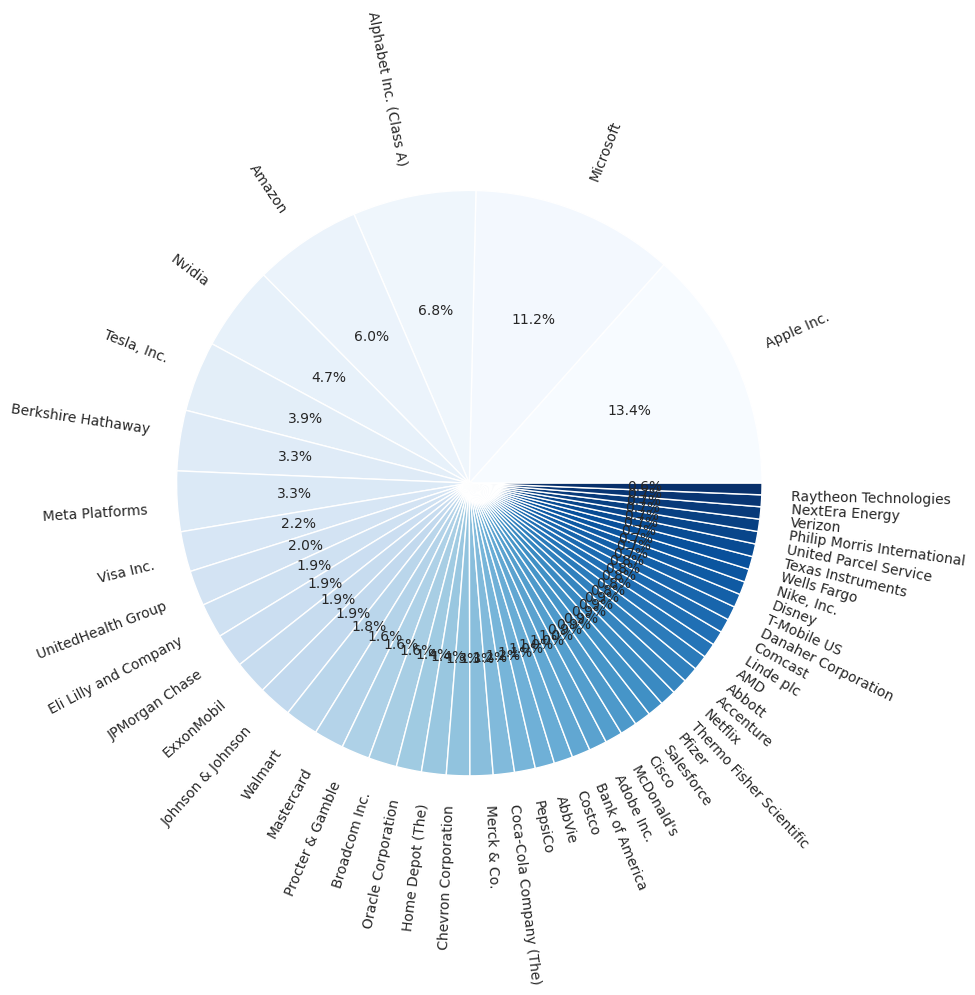

In [83]:
market_cap = market_cap.rename(index=columns)
(market_cap.sort_values(by='cap',ascending=False)/market_cap.sum())[:stock_range].plot.pie(subplots=True, legend=False,
                                                                                  figsize=(10,10), cmap='Blues',
                                                                                  autopct='%.1f%%', fontsize=10, ylabel='',rotatelabels=True)
plt.tight_layout()

---